**Описание набора данных**

Набор данных представляет собой данные с отзывами и рейтингами авиакомпаний пассажирами о различных аспектах их впечатлений от полетов в различных авиакомпаниях.

Названия и описания колонок набора данных:

*   Aircraft Type: Тип воздушного судна, используемого для полета
*   Users Reviews: Тексты отзывов, предоставленных пользователями
*   Country: Страна авиакомпании или отправления/пункта назначения рейса
*   Type of Travellers: Классификация путешественников (например, одиноких, семейных, деловых...)
*   Route: Выбранный маршрут полета
*   Seat Types: Класс места (Эконом, Бизнес, Первый класс...)
*   Seat Comfort: Оценка комфортности места
*   Date Flown: Дата полета
*   Cabin Staff Service: Оценка сервиса, предоставляемого персоналом салона
*   Ground Service/Floor: Оценка наземного обслуживания, включая регистрацию на рейс и посадку
*   Food & Beverages: Оценка качества питания и напитков
*   Wifi & Connectivity: Рейтинг доступных возможностей Wi-Fi и подключений
*   Inflight Entertainment: Рейтинг вариантов развлечений в полете
*   Value For Money: Общий рейтинг соотношения цены и качества
*   Recommended: Итоговая рекомендация авиакомпании пользователем

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.io import arff
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
sns.set(style="ticks")

In [ ]:
data_loaded = pd.read_csv('Airlines Reviews and Rating.csv', sep=",")

In [ ]:
data = data_loaded

In [ ]:
list(zip(data.columns, [i for i in data.dtypes]))

[('Aircraft Type', dtype('O')),
 ('Users Reviews', dtype('O')),
 ('Country', dtype('O')),
 ('Type_of_Travellers', dtype('O')),
 ('Route', dtype('O')),
 ('Seat_Types', dtype('O')),
 ('Seat Comfort', dtype('float64')),
 ('Date Flown', dtype('O')),
 ('Cabin Staff Service', dtype('float64')),
 ('Ground Service', dtype('float64')),
 ('Food & Beverages', dtype('float64')),
 ('Wifi & Connectivity', dtype('float64')),
 ('Inflight Entertainment', dtype('float64')),
 ('Value For Money', dtype('int64')),
 ('Recommended', dtype('O'))]

In [ ]:
# Колонки с пропусками
cols_with_na = [c for c in data.columns if data[c].isnull().sum() > 0]
cols_with_na

['Aircraft Type',
 'Country',
 'Type_of_Travellers',
 'Route',
 'Seat_Types',
 'Seat Comfort',
 'Date Flown',
 'Cabin Staff Service',
 'Ground Service',
 'Food & Beverages',
 'Wifi & Connectivity',
 'Inflight Entertainment']

In [ ]:
data_loaded.shape

(3290, 15)

In [ ]:
# Количество пропусков
[(c, data[c].isnull().sum()) for c in cols_with_na]

[('Aircraft Type', 1394),
 ('Country', 1),
 ('Type_of_Travellers', 403),
 ('Route', 407),
 ('Seat_Types', 3),
 ('Seat Comfort', 114),
 ('Date Flown', 410),
 ('Cabin Staff Service', 125),
 ('Ground Service', 478),
 ('Food & Beverages', 379),
 ('Wifi & Connectivity', 2698),
 ('Inflight Entertainment', 1119)]

In [ ]:
# Доля пропусков
[(c, (data[c].isnull().mean()) * 100) for c in cols_with_na]

[('Aircraft Type', 42.37082066869301),
 ('Country', 0.030395136778115502),
 ('Type_of_Travellers', 12.249240121580547),
 ('Route', 12.37082066869301),
 ('Seat_Types', 0.0911854103343465),
 ('Seat Comfort', 3.4650455927051675),
 ('Date Flown', 12.462006079027356),
 ('Cabin Staff Service', 3.7993920972644375),
 ('Ground Service', 14.52887537993921),
 ('Food & Beverages', 11.519756838905774),
 ('Wifi & Connectivity', 82.00607902735563),
 ('Inflight Entertainment', 34.01215805471124)]

In [ ]:
data.drop('Wifi & Connectivity', axis=1 , inplace= True)

In [ ]:
data.dropna(subset=['Country', 'Seat_Types', 'Seat Comfort', 'Cabin Staff Service'], inplace=True)

In [ ]:
cols_with_na = [c for c in data.columns if data[c].isnull().sum() > 0]
[(c, data[c].isnull().sum()) for c in cols_with_na]

[('Aircraft Type', 1278),
 ('Type_of_Travellers', 399),
 ('Route', 402),
 ('Date Flown', 407),
 ('Ground Service', 410),
 ('Food & Beverages', 254),
 ('Inflight Entertainment', 994)]

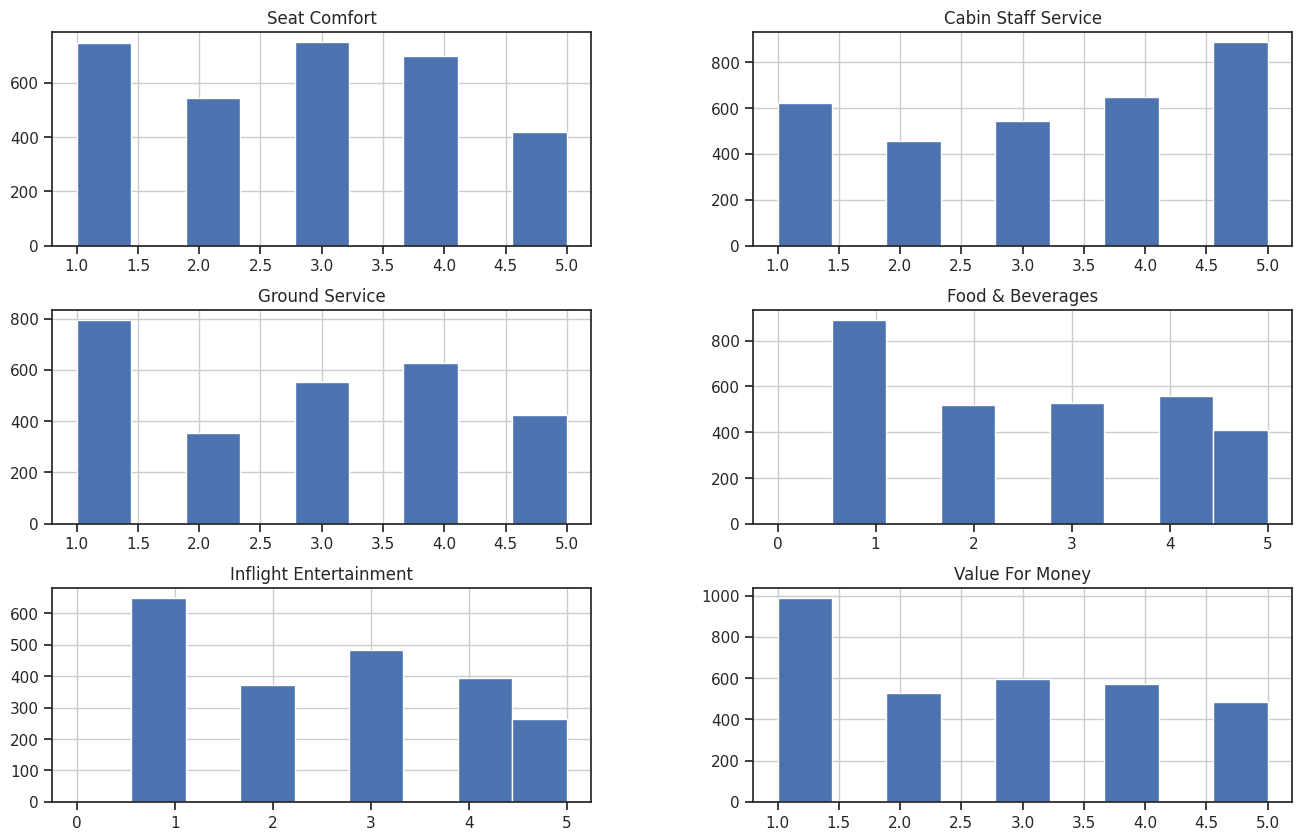

In [ ]:
data.hist(bins=9, figsize=(16,10))
plt.show()

In [ ]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]

    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)

    imputer = SimpleImputer(strategy=strategy_param,
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)

    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]

    return all_data.reshape((size,)), filled_data, missed_data

In [ ]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))

    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))

    new_df = pd.DataFrame({'Исходные данные':original_data})

    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data

    sns.kdeplot(data=new_df)

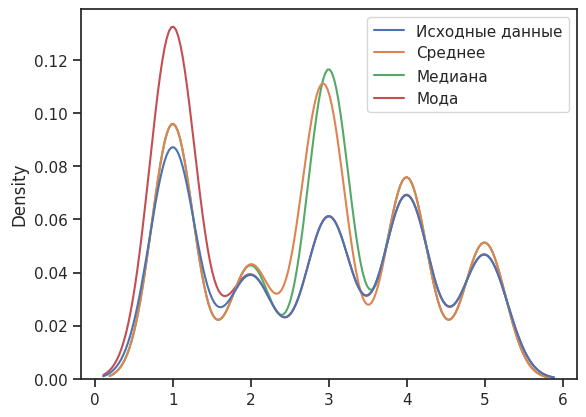

In [ ]:
research_impute_numeric_column(data, 'Ground Service')

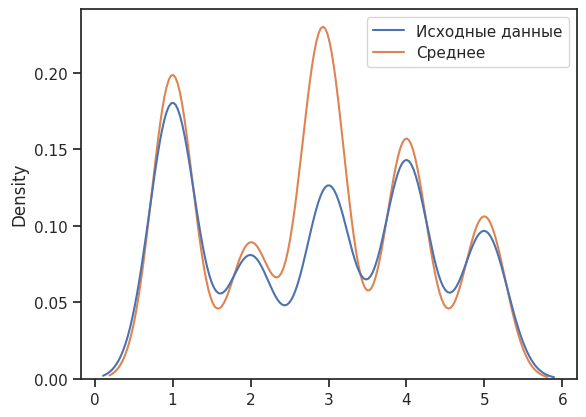

In [ ]:
# Построение графика разницы между исходными данными признака и данными признака со средним вместо пропусков.
temp_data = data[['Ground Service']].values
size = temp_data.shape[0]
new_df = pd.DataFrame({'Исходные данные':temp_data.reshape((size,))})
imputer = SimpleImputer(strategy='mean')
temp_data_filled = imputer.fit_transform(temp_data)
new_df['Среднее'] = temp_data_filled.reshape((size,))
sns.kdeplot(data=new_df)
data.drop('Ground Service', axis=1 , inplace= True)
data['Ground Service'] = new_df['Среднее']
# Замена данных указанного признака на данные со средним вместо пропусков.

In [ ]:
cols_with_na = [c for c in data.columns if data[c].isnull().sum() > 0]
[(c, data[c].isnull().sum()) for c in cols_with_na]

[('Aircraft Type', 1278),
 ('Type_of_Travellers', 399),
 ('Route', 402),
 ('Date Flown', 407),
 ('Food & Beverages', 254),
 ('Inflight Entertainment', 994),
 ('Ground Service', 129)]

In [ ]:
IQR = data['Food & Beverages'].quantile(0.75) - data['Food & Beverages'].quantile(0.25)
FoodBeverages_ev1 = data['Food & Beverages'].quantile(0.75) + 3*IQR
print('IQR={}, extreme_value={}'.format(IQR, FoodBeverages_ev1))

IQR=3.0, extreme_value=13.0


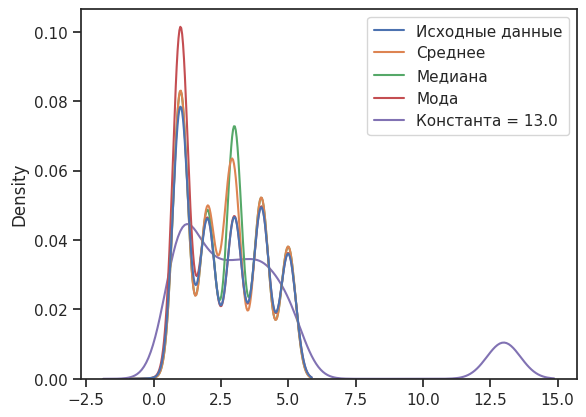

In [ ]:
research_impute_numeric_column(data, 'Food & Beverages', FoodBeverages_ev1)

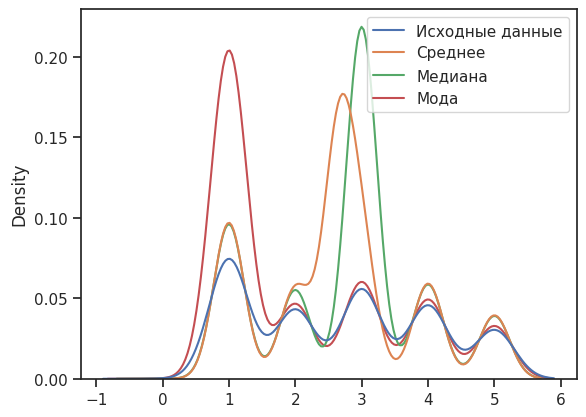

In [ ]:
research_impute_numeric_column(data, 'Inflight Entertainment')

<Axes: ylabel='Density'>

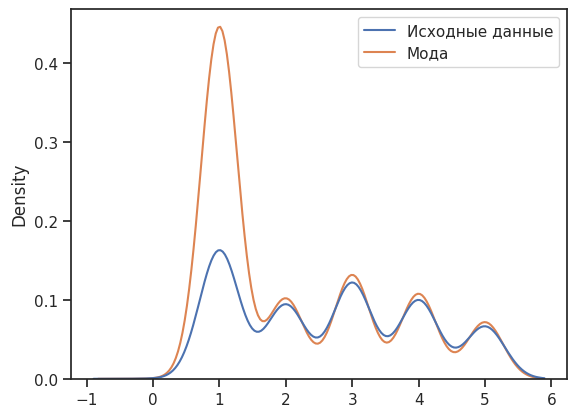

In [ ]:
# Построение графика разницы между исходными данными признака и данными признака со средним вместо пропусков.
temp_data = data[['Inflight Entertainment']].values
size = temp_data.shape[0]
new_df = pd.DataFrame({'Исходные данные':temp_data.reshape((size,))})
imputer = SimpleImputer(strategy='most_frequent')
temp_data_filled = imputer.fit_transform(temp_data)
new_df['Мода'] = temp_data_filled.reshape((size,))
sns.kdeplot(data=new_df)

# Замена данных указанного признака на данные с модой вместо пропусков.
#data['Inflight Entertainment'] = data['Inflight Entertainment'].replace(new_df['Мода'])
#data.update(new_df['Мода'])
#data.drop('Inflight Entertainment', axis=1 , inplace= True)
#data['Inflight Entertainment'] = new_df['Мода']

In [ ]:
data_cat_cols = ['Aircraft Type', 'Route','Date Flown']
data_cat_new = data[data_cat_cols].copy()

In [ ]:
AircraftType_cat_new_temp, _, _ = impute_column(data_cat_new, 'Aircraft Type', 'most_frequent')
Route_cat_new_temp, _, _ = impute_column(data_cat_new, 'Route', 'most_frequent')
DateFlown_cat_new_temp, _, _ = impute_column(data_cat_new, 'Date Flown', 'most_frequent')

In [ ]:
data_cat_new['Aircraft Type'] = AircraftType_cat_new_temp
data_cat_new['Route'] = Route_cat_new_temp
data_cat_new['Date Flown'] = DateFlown_cat_new_temp

In [ ]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

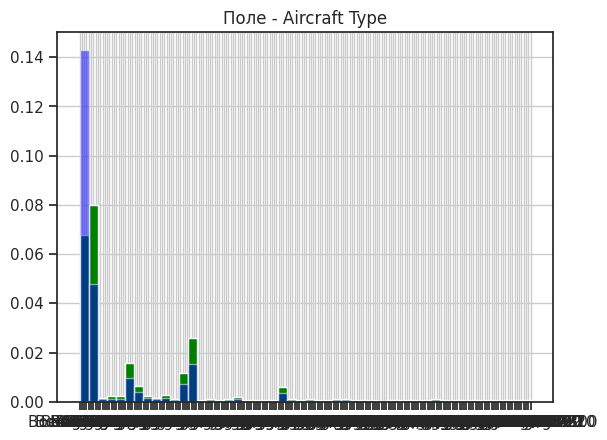

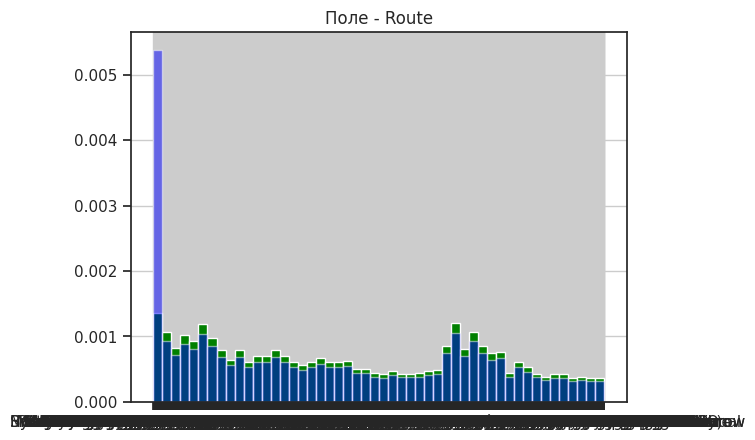

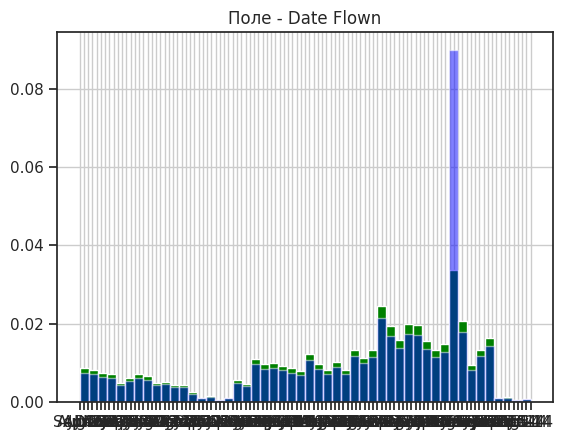

In [ ]:
plot_hist_diff(data, data_cat_new, data_cat_cols)

Кодирование категорий наборами бинарных значений - one-hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(data[['Recommended']])
#cat_enc_ohe

In [ ]:
#cat_enc_ohe.todense()[0:10]

In [ ]:
pd.get_dummies(data[['Aircraft Type']]).head()

,Aircraft Type_767-300,Aircraft Type_777,Aircraft Type_777-200,Aircraft Type_777-300,Aircraft Type_787,Aircraft Type_A19,Aircraft Type_A219,Aircraft Type_A230,Aircraft Type_A318,Aircraft Type_A319,...,Aircraft Type_Embraer 170,Aircraft Type_Embraer 190,Aircraft Type_Embraer 195,Aircraft Type_Embraer E190,Aircraft Type_Embraer-190,Aircraft Type_Embraer170,Aircraft Type_SAAB 2000,Aircraft Type_Saab 2000,Aircraft Type_Various,Aircraft Type_boeing 787
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Добавление отдельной колонки, признака пустых значений
pd.get_dummies(data[['Aircraft Type']], dummy_na=True).head()

,Aircraft Type_767-300,Aircraft Type_777,Aircraft Type_777-200,Aircraft Type_777-300,Aircraft Type_787,Aircraft Type_A19,Aircraft Type_A219,Aircraft Type_A230,Aircraft Type_A318,Aircraft Type_A319,...,Aircraft Type_Embraer 190,Aircraft Type_Embraer 195,Aircraft Type_Embraer E190,Aircraft Type_Embraer-190,Aircraft Type_Embraer170,Aircraft Type_SAAB 2000,Aircraft Type_Saab 2000,Aircraft Type_Various,Aircraft Type_boeing 787,Aircraft Type_nan
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Count (frequency) encoding

In [ ]:
!pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
from category_encoders.count import CountEncoder as ce_CountEncoder
#from sklearn import category_encoders as ce
#from category_encoders.count import CountEncoder as ce_CountEncoder

In [ ]:
ce_CountEncoder1 = ce_CountEncoder()
data_COUNT_ENC = ce_CountEncoder1.fit_transform(data[data.columns.difference(['Recommended'])])

In [ ]:
data_COUNT_ENC

,Aircraft Type,Cabin Staff Service,Country,Date Flown,Food & Beverages,Ground Service,Inflight Entertainment,Route,Seat Comfort,Seat_Types,Type_of_Travellers,Users Reviews,Value For Money
0,1278,1.0,1975,9,1.0,2.0,3.0,2,1.0,1639,944,1,1
1,1278,3.0,353,18,2.0,1.0,1.0,1,1.0,1016,843,1,1
2,1278,3.0,353,9,3.0,1.0,NaN,1,1.0,1016,598,1,1
3,1278,1.0,1975,9,1.0,1.0,1.0,4,1.0,1639,598,1,1
4,1278,2.0,25,18,3.0,1.0,3.0,1,3.0,1639,377,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,1278,2.0,1975,407,1.0,NaN,3.0,402,3.0,1016,399,1,2
3286,1278,5.0,1975,407,5.0,NaN,5.0,402,4.0,1016,399,1,4
3287,1278,1.0,1975,407,1.0,NaN,2.0,402,3.0,1016,399,1,1
3288,1278,5.0,353,407,4.0,NaN,4.0,402,5.0,1016,399,1,4


In [ ]:
data['Country'].unique()

array(['United Kingdom', 'United States', 'France', 'Germany', 'Canada',
       'Kuwait', 'Iceland', 'Australia', 'Poland', 'Hong Kong', 'Qatar',
       'Spain', 'South Africa', 'Greece', 'Italy', 'Senegal',
       'United Arab Emirates', 'Romania', 'Cyprus', 'Chile', 'Sweden',
       'Ireland', 'Netherlands', 'Austria', 'India', 'Belgium',
       'New Zealand', 'Czech Republic', 'Malaysia', 'Singapore',
       'Switzerland', 'Bermuda', 'Botswana', 'Brazil', 'Panama',
       'Russian Federation', 'Ghana', 'Bulgaria', 'Thailand', 'Argentina',
       'Mexico', 'Denmark', 'Saint Kitts and Nevis', 'Vietnam', 'Norway',
       'Jordan', 'Japan', 'China', 'Slovakia', 'Israel', 'South Korea',
       'Saudi Arabia', 'Hungary', 'Nigeria', 'Portugal', 'Taiwan',
       'Cayman Islands', 'Costa Rica', 'Egypt', 'Laos', 'Turkey',
       'Indonesia', 'Dominican Republic', 'Luxembourg', 'Philippines',
       'Finland', 'Ukraine'], dtype=object)

In [ ]:
data_COUNT_ENC['Country'].unique()

array([1975,  353,   25,   60,   96,    6,    5,  123,    8,   13,    7,
         28,   34,   14,   18,    1,   22,   19,   31,    9,   27,   10,
         26,   32,    2,    4,   21,    3,   12])

In [ ]:
ce_CountEncoder2 = ce_CountEncoder(normalize=True)
data_FREQ_ENC = ce_CountEncoder2.fit_transform(data[data.columns.difference(['Recommended'])])

In [ ]:
data_FREQ_ENC

,Aircraft Type,Cabin Staff Service,Country,Date Flown,Food & Beverages,Ground Service,Inflight Entertainment,Route,Seat Comfort,Seat_Types,Type_of_Travellers,Users Reviews,Value For Money
0,0.404302,1.0,0.624802,0.002847,1.0,2.0,3.0,0.000633,1.0,0.518507,0.298640,0.000316,1
1,0.404302,3.0,0.111674,0.005694,2.0,1.0,1.0,0.000316,1.0,0.321417,0.266688,0.000316,1
2,0.404302,3.0,0.111674,0.002847,3.0,1.0,NaN,0.000316,1.0,0.321417,0.189181,0.000316,1
3,0.404302,1.0,0.624802,0.002847,1.0,1.0,1.0,0.001265,1.0,0.518507,0.189181,0.000316,1
4,0.404302,2.0,0.007909,0.005694,3.0,1.0,3.0,0.000316,3.0,0.518507,0.119266,0.000316,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,0.404302,2.0,0.624802,0.128757,1.0,NaN,3.0,0.127175,3.0,0.321417,0.126226,0.000316,2
3286,0.404302,5.0,0.624802,0.128757,5.0,NaN,5.0,0.127175,4.0,0.321417,0.126226,0.000316,4
3287,0.404302,1.0,0.624802,0.128757,1.0,NaN,2.0,0.127175,3.0,0.321417,0.126226,0.000316,1
3288,0.404302,5.0,0.111674,0.128757,4.0,NaN,4.0,0.127175,5.0,0.321417,0.126226,0.000316,4


In [ ]:
data_FREQ_ENC['Seat_Types'].unique()

array([0.5185068 , 0.32141727, 0.09838659, 0.06168934])

Нормализация числовых признаков

In [ ]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

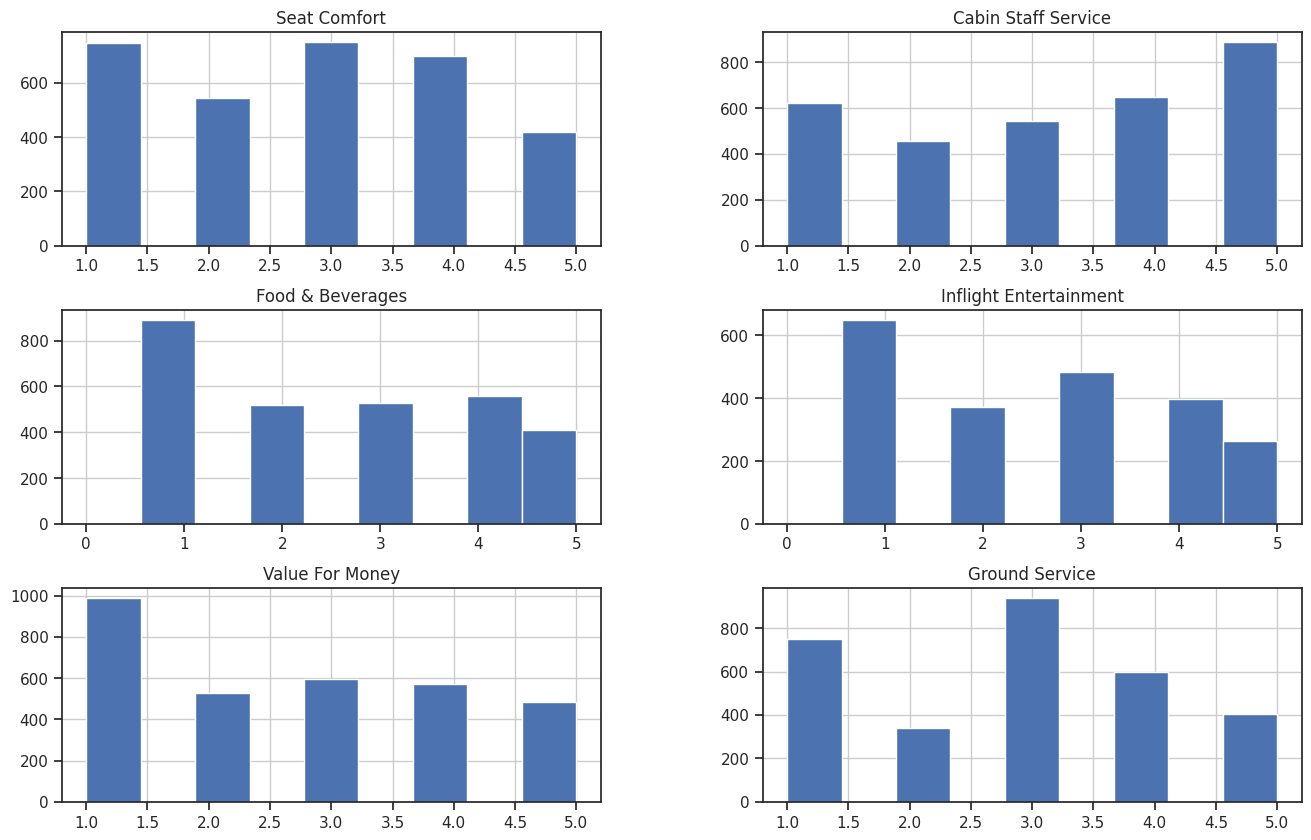

In [ ]:
data.hist(bins=9, figsize=(16,10))
plt.show()

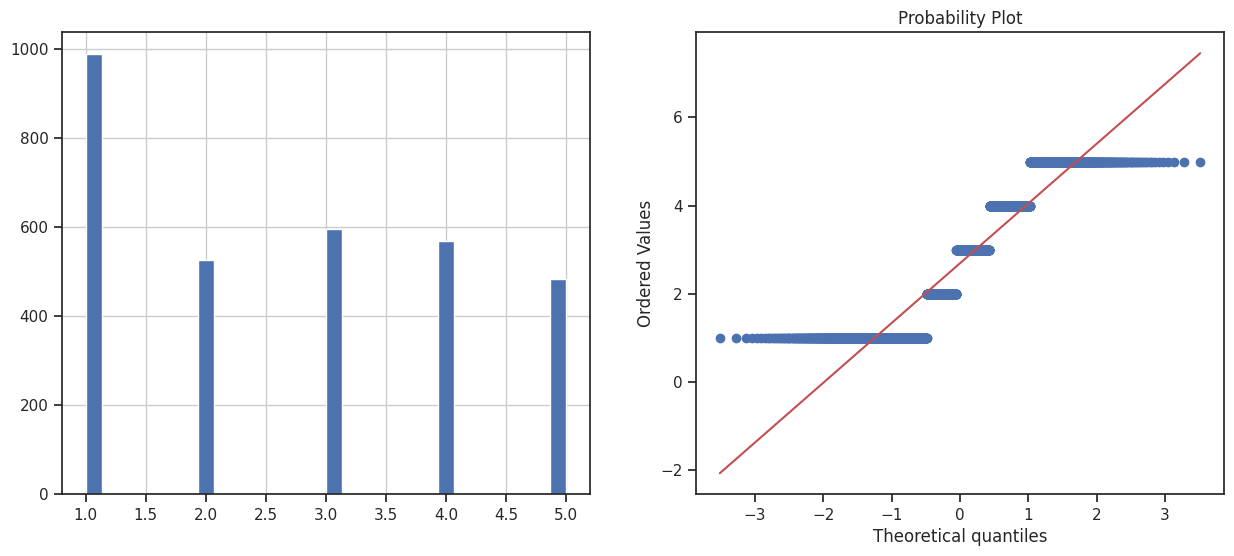

In [ ]:
diagnostic_plots(data, 'Value For Money')

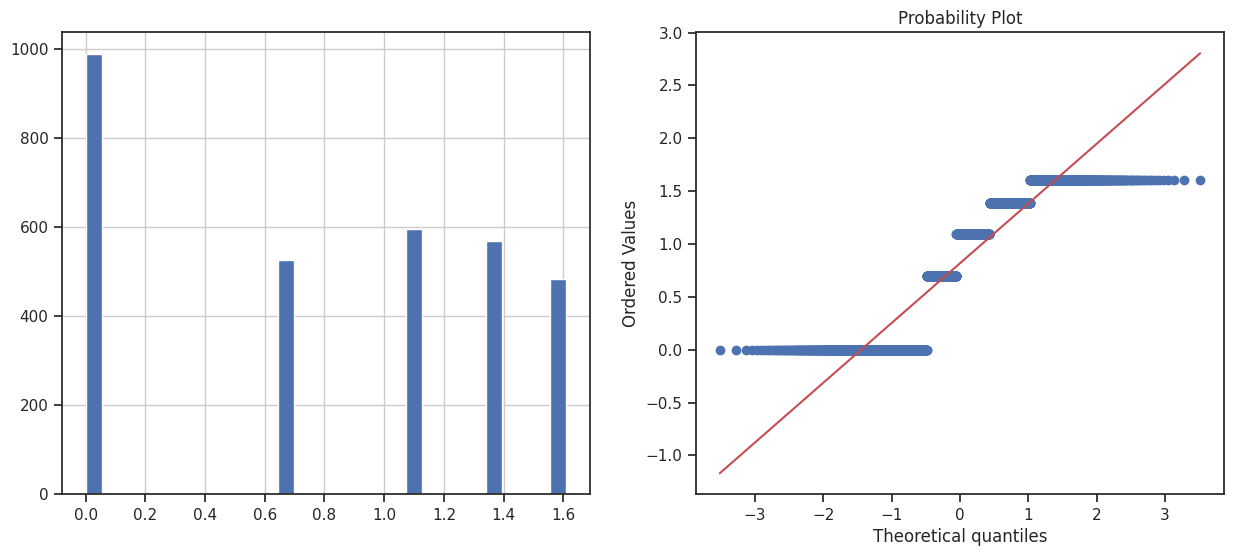

In [ ]:
data['ValueForMoney_log'] = np.log(data['Value For Money'])
diagnostic_plots(data, 'ValueForMoney_log')

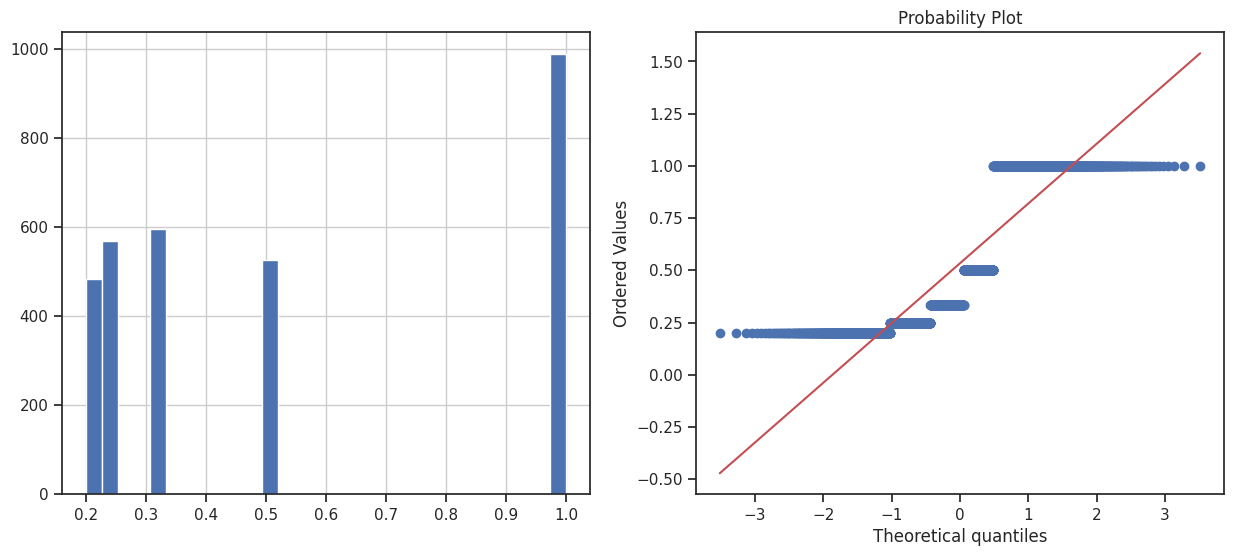

In [ ]:
data['ValueForMoney_reciprocal'] = 1 / (data['Value For Money'])
diagnostic_plots(data, 'ValueForMoney_reciprocal')

Оптимальное значение λ = 0.3268299720218398


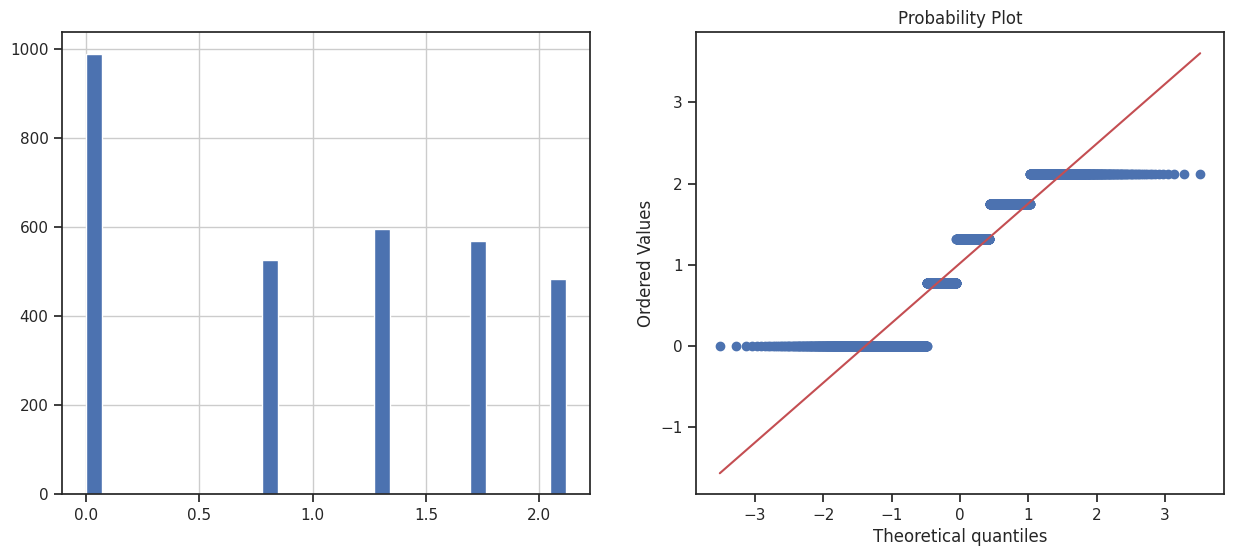

In [ ]:
data['ValueForMoney_boxcox'], param = stats.boxcox(data['Value For Money'])
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'ValueForMoney_boxcox')

Оптимальное значение λ = 0.21240355701789615


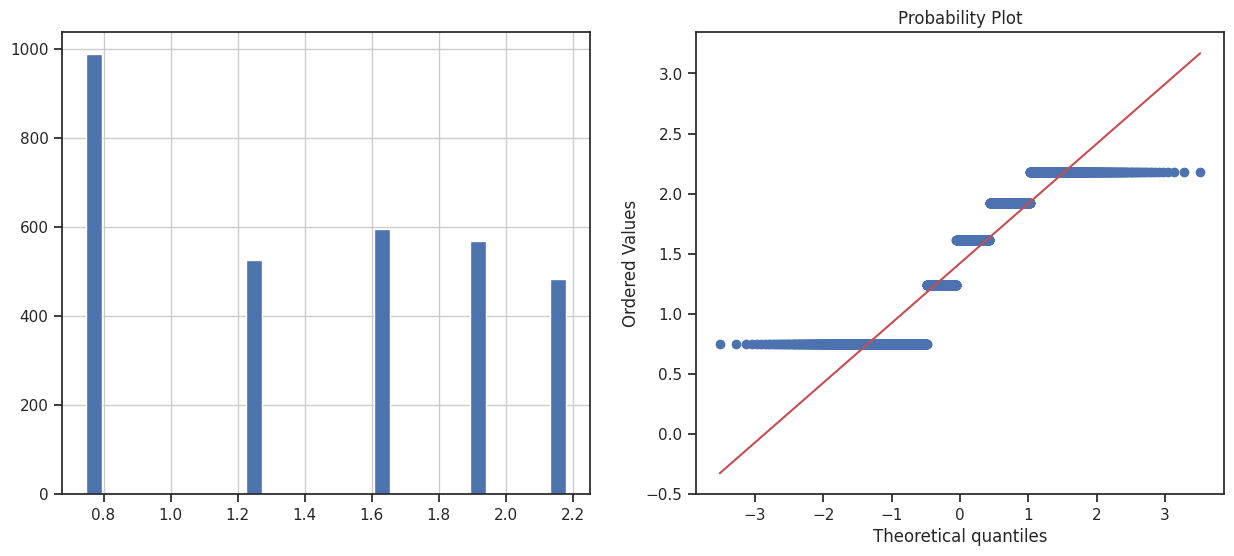

In [ ]:
# Необходимо преобразовать данные к действительному типу
data['Value For Money'] = data['Value For Money'].astype('float')
data['ValueForMoney_yeojohnson'], param = stats.yeojohnson(data['Value For Money'])
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'ValueForMoney_yeojohnson')

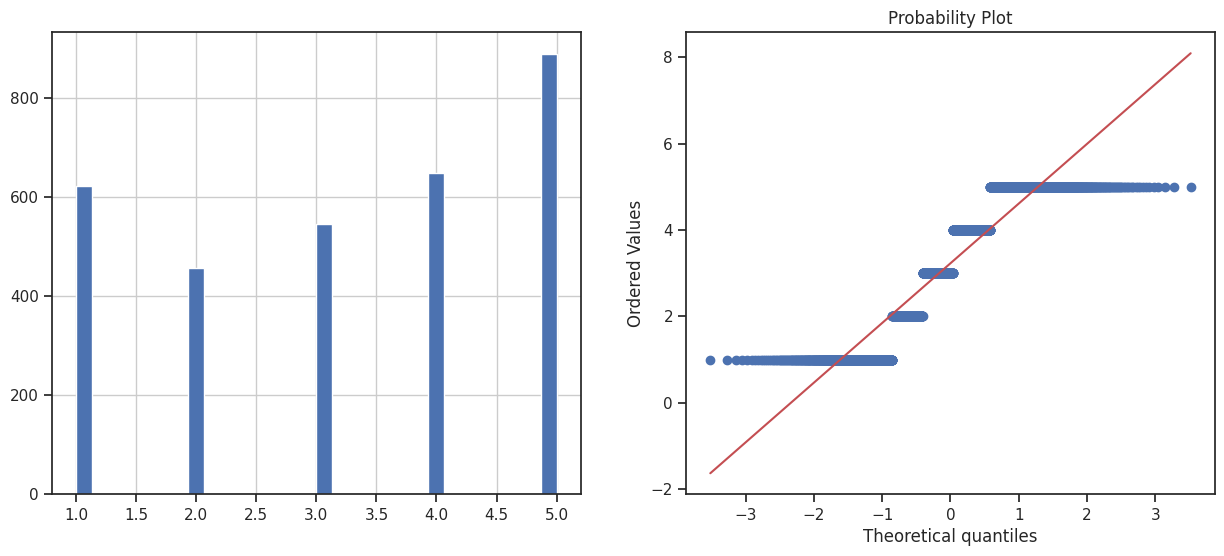

In [ ]:
diagnostic_plots(data, 'Cabin Staff Service')

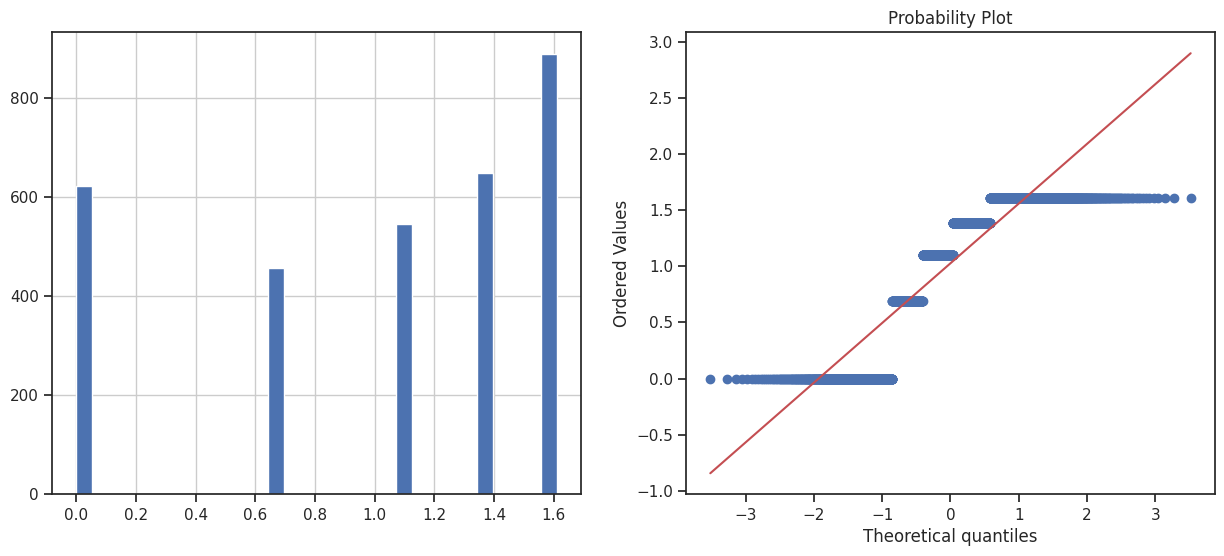

In [ ]:
data['CabinStaffService_log'] = np.log(data['Cabin Staff Service'])
diagnostic_plots(data, 'CabinStaffService_log')

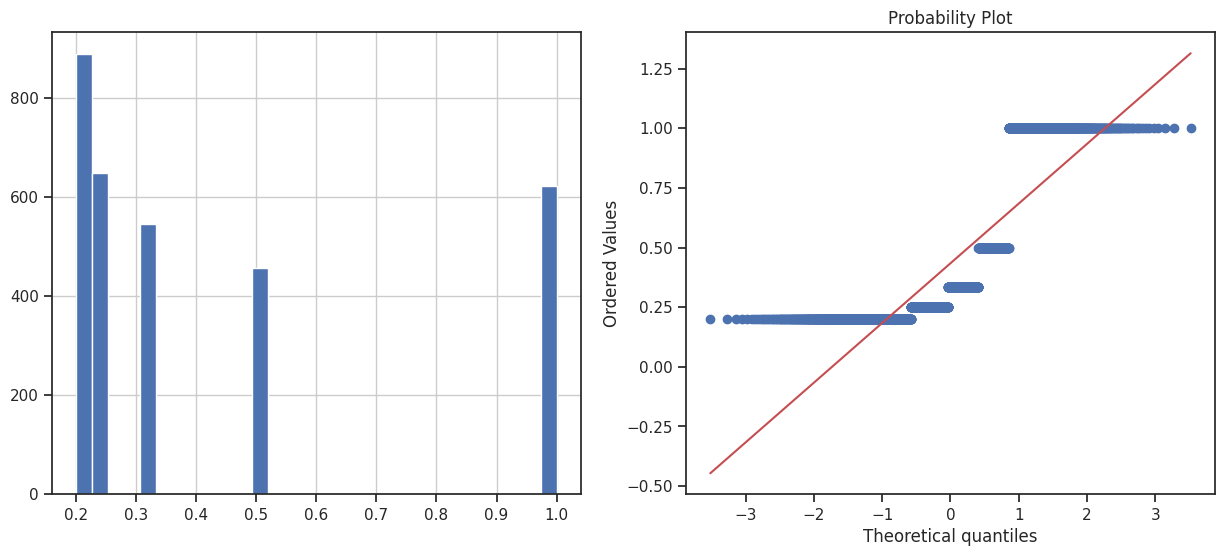

In [ ]:
data['CabinStaffService_reciprocal'] = 1 / (data['Cabin Staff Service'])
diagnostic_plots(data, 'CabinStaffService_reciprocal')

Оптимальное значение λ = 0.9351167125436567


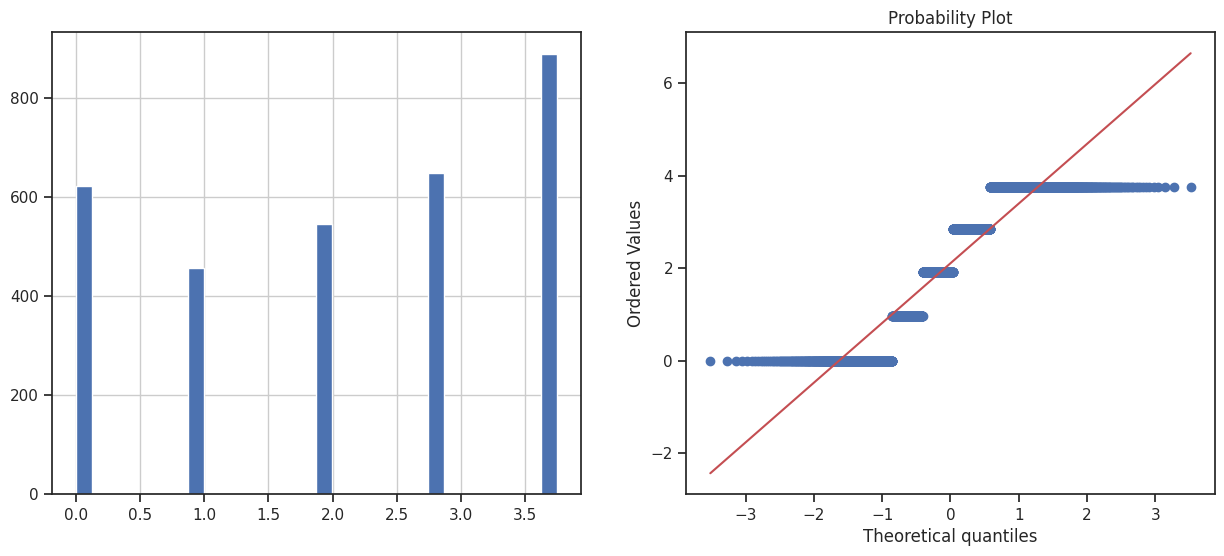

In [ ]:
data['CabinStaffService_boxcox'], param = stats.boxcox(data['Cabin Staff Service'])
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'CabinStaffService_boxcox')

Оптимальное значение λ = 1.0849396458669511


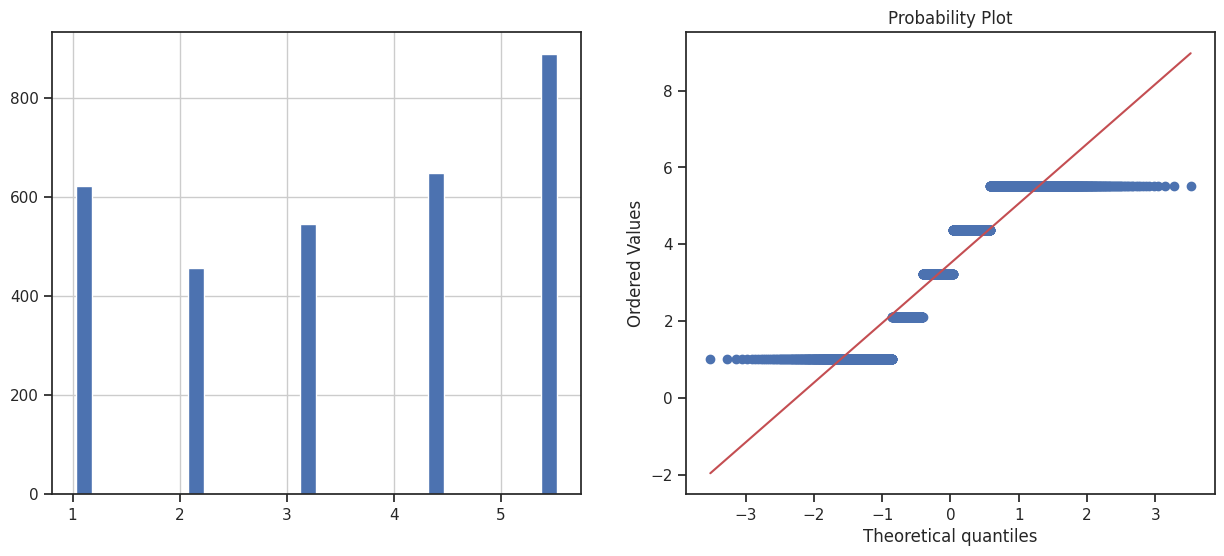

In [ ]:
# Необходимо преобразовать данные к действительному типу
data['Cabin Staff Service'] = data['Cabin Staff Service'].astype('float')
data['CabinStaffService_yeojohnson'], param = stats.yeojohnson(data['Cabin Staff Service'])
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'CabinStaffService_yeojohnson')